In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries


def get2dPucks(abin, apix, npucks=10, vis=False):
    '''
    get2dPucks(abin, apix): Return the linear extent of the binary structure,
    as well as a sequence of radii about that extent.
    '''
    
    # Empty bin?
    if ~np.any(abin):
        return 1.0, np.zeros((npucks,))
    
    x,y = np.where(abin>0)
    X = np.stack([x,y]) # Coords of all non-zero pixels., 2 x N
    if X.shape[1] < 1: # no pixels, doesn't seem to be a problem usually. 
        return (0.0, np.zeros((npucks,)))
    # Scale dimensions
    X = np.multiply(X, np.array(apix)[:, None]) # Need a broadcastable shape, here 2 x 1
    try:
        val, vec = np.linalg.eig(np.cov(X, rowvar=True))
    except:
        return (0.0, np.zeros((npucks,)))
    
    # Make sure we're in decreasing order of importance.
    eigorder = np.argsort(val)[-1::-1]
    vec = vec[:, eigorder]
    val = val[eigorder]
    
    # Negate the eigenvectors for consistency. Let's say y should be positive eig0,
    # and x should be positive for eig1. I'm not sure if that's what I'm doing here,
    # but just trying to be consistent.
    if vec[0,0] < 0:
        vec[:,0] = -1.0*vec[:,0]
    if vec[1,1] < 0:
        vec[:,1] = -1.0*vec[:,1]
    
    
    mu = np.expand_dims(np.mean(X, axis=1), axis=1)
    
    # Now mu is 2 x 1 mean pixel coord 
    # val is eigenvalues, vec is 2 x 2 right eigvectors (by column), all in matrix ij format
    
    # Use the boundary to get the radii.
    # Project the boundary pixel coords into the eigenspace.
    B = find_boundaries(abin, mode='thick')
    Xb = np.stack(np.where(B))
    Xb = np.multiply(Xb, np.array(apix)[:, None]) # space coords again.
    proj = np.dot((Xb-mu).T,vec) 
    # proj is M x 2, the projections onto 0 and 1 eigs of the M boundary coords.
    
    
    # Now get min max in the first principal direction. That's L! Just L[0] here.
    L_min, L_max = np.min(proj, axis=0), np.max(proj, axis=0)
    L = L_max - L_min
    
    # Partition along the principal axis. The secondary axis represents the radii.
    L_partition = np.linspace(L_min[0], L_max[0], npucks+1)
    
    R = []
    A = np.copy(proj)
    for i in range(len(L_partition)-1):
        # Select those boundary points whose projection on the major axis
        # is within the thresholds. 
        which = np.logical_and(A[:,0] >= L_partition[i],
                               A[:,0] < L_partition[i+1])
        # here which could be empty, if there are multiple components to the binary,
        # which will happen without cleaning for the largest connected component and 
        # such. r will be nan, here I replace with zero.
        # In fact, this math really only works well with nice convex objects.
        if len(which) == 0:
            r = 0
        else:
            r = np.median(np.abs(A[:,1][which]))
        R.append(r)
    
    
    if vis:
        # Some visualization code I didn't know where else to put!
        # B is still in image coords, while mu and the vec and L's are in mm? Use extent.
        # extent = (-0.5, apix[1]*B.shape[1]-0.5, -0.5, apix[0]*B.shape[0]-0.5)# (left, right, bottom, top)
        
        # This got me pretty confused. The issue is that if apix is something other than (1,1), then 
        # B needs to be scaled accordingly. 
        # If apix is significantly less than 1,1, then the 0 order and no anti-aliasing could
        # leave little of the boundary left. Though it would only affect the vis, as the calculation
        # above scaled the boundary points to double, instead of this which returns pixels.
        abin_scaled = rescale(abin, apix, order=0, 
                              preserve_range=True, 
                              anti_aliasing=False, 
                              multichannel=False)
        Bscaled = find_boundaries(abin_scaled, mode='thick')
        
        plt.figure(figsize=(5,5))
        plt.imshow(Bscaled) # , origin='upper', extent=extent)
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
        

        # Plot the mean and principal projections. But plot needs xy (euclid) instead of ij (matrix)!!!
        # Stupid, keeping the sliced out dimension with None here.
        pca0 = np.array([mu + L_min[0]*vec[:,0, None], mu + L_max[0]*vec[:,0, None]])
        pca1 = np.array([mu + L_min[1]*vec[:,1, None], mu + L_max[1]*vec[:,1, None]])

        # Notice the x and y coord reversed. 
        plt.scatter(x=mu[1], y=mu[0], s=30, marker='*')
        plt.scatter(x=pca0[:,1], y=pca0[:,0], c = [[.2, .4, .2], [.6, .9, .6]]) # Dark green to light green
        plt.scatter(x=pca1[:,1], y=pca1[:,0], c = [[.4, .2, .2], [.9, .6, .6]]) # Dark red to light red

        plt.plot(pca0[:,1], pca0[:,0], 'g--')
        plt.plot(pca1[:,1], pca1[:,0], 'r--')

        for i in range(len(L_partition)-1):
            extent = (L_partition[i]+L_partition[i+1])/2
            points = np.array([mu + extent*vec[:,0, None] - R[i]*vec[:,1, None], # negative radius
                               mu + extent*vec[:,0, None] + R[i]*vec[:,1, None]]) # positive radius
            plt.plot(points[:,1], points[:,0])
            
        
        plt.gca().set_aspect('equal')
        plt.axis('equal')
#         plt.axis('square')

        # title 2d area and approximation.
        plt.suptitle('Actual scaled area {:.2f}, approx {:.2f}'.format(np.prod(apix)*abin.sum(), 
                                                                       (L[0]/npucks)*2*np.sum(R)))
#         plt.tight_layout()
    
    return L[0], np.array(R)

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

100%|██████████| 16/16 [00:01<00:00, 14.53it/s]


In [6]:
def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)
    

# from queue import SimpleQueue as squeue
def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

In [7]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


### 1. Function for computing EF using fused segmentations

In [8]:
pucks_ed = []
pucks_es = []

In [9]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def segment_a_video_with_fusion(video, interpolate_last=True, step=1, num_clips=10, 
                                fuse_method="simple", class_list=[0, 1]):
    if video.shape[1] < 32 + num_clips * step:
        num_clips = (video.shape[1] - 32) // step
    if num_clips < 0:
        print("Video is too short")
        num_clips = 1
    all_consecutive_clips = []

    for shift_dis in range(0, num_clips * step, step):
        shifted_video = video[:, shift_dis:]
        consecutive_clips = divide_to_consecutive_clips(shifted_video, interpolate_last=interpolate_last)
        all_consecutive_clips.append(consecutive_clips)

    all_consecutive_clips = np.array(all_consecutive_clips)
    all_segmentations = []

    for i in range(len(all_consecutive_clips)):
        consecutive_clips = all_consecutive_clips[i]
        segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))

        for i in range(consecutive_clips.shape[0]):
            one_clip = np.expand_dims(consecutive_clips[i], 0)
            segmentation_output, motion_output = model(torch.Tensor(one_clip))
            segmentation_output = F.softmax(segmentation_output, 1)
            segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        segmentation_outputs = segmentation_outputs[1:]

        all_segmentations.append(segmentation_outputs)

    for i in range(len(all_segmentations)):
        all_segmentations[i] = all_segmentations[i].transpose([1, 0, 2, 3, 4])
        all_segmentations[i] = all_segmentations[i].reshape(2, -1, 112, 112)

    all_interpolated_segmentations = []
    for i in range(0, len(all_consecutive_clips)):
        video_clip = video[:, i * step:]
        if interpolate_last and (video_clip.shape[1] % 32 != 0):
            interpolated_segmentations = torch.Tensor(all_segmentations[i]).unsqueeze(0)
            interpolated_segmentations = F.interpolate(interpolated_segmentations, size=(video_clip.shape[1], 112, 112), 
                                                       mode="trilinear", align_corners=False)
            interpolated_segmentations = interpolated_segmentations.squeeze(0).numpy()
            all_interpolated_segmentations.append(np.argmax(interpolated_segmentations, 0))
        else:
            all_interpolated_segmentations.append(np.argmax(all_segmentations[i], 0))

    fused_segmentations = [all_interpolated_segmentations[0][0]]

    for i in range(1, video.shape[1]):
        if step - 1 < i:
            images_to_fuse = []
            for index in range(min(i, len(all_interpolated_segmentations))):
                if i - index * step < 0:
                    break
                images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[index][i - index * step].astype("uint8"),
                                                            isVector=False))
            if len(images_to_fuse) <= 1:
                fused_segmentations.append(itk.GetArrayFromImage(images_to_fuse[0]))
            else:
                fused_image = fuse_images(images_to_fuse, fuse_method, class_list=class_list)
                # If using SIMPLE, the fused image might be in type "float"
                # So convert it to uint
                fused_segmentations.append(itk.GetArrayFromImage(fused_image).astype("uint8"))

    fused_segmentations = np.array(fused_segmentations)
    
    return fused_segmentations


def compute_ef_using_putative_clips(fused_segmentations, test_pat_index):
    size = np.sum(fused_segmentations, axis=(1, 2)).ravel()
    _05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

    trim_min = _05cut
    trim_max = _95cut
    trim_range = trim_max - trim_min
    systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
    diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

    # keep only real diastoles..
    diastole = [x for x in diastole if size[x] >= _85cut]
    # Add first frame
    if np.mean(size[:3]) >= _85cut:
        diastole = [0] + diastole
    diastole = np.array(diastole)

    clip_pairs = EDESpairs(diastole, systole)

    one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

    predicted_efs = []

    for i in range(len(clip_pairs)):
        output_ED = one_array_of_segmentations[clip_pairs[i][0]]
        output_ES = one_array_of_segmentations[clip_pairs[i][1]]
        
        length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
        length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

        edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
        esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

        ef_predicted = (edv - esv) / edv * 100
        
        if ef_predicted < 0:
            print("Negative EF at patient:{:04d}".format(test_pat_index))
            continue

        predicted_efs.append(ef_predicted)

    return predicted_efs


def compute_ef_using_reported_clip(segmentations, ed_index, es_index):
    output_ED = segmentations[ed_index]
    output_ES = segmentations[es_index]

    lv_ed_dice = categorical_dice((output_ED), ed_label, 1)
    lv_es_dice = categorical_dice((output_ES), es_label, 1)

    print('inputs into get2dPucks:')
    print(f'output_ED.shape: {output_ED.shape}')
    print(f'output_ES.shape: {output_ES.shape}')
    
    print(f'output_ED unique vals: {np.unique(output_ED)}')
    
    length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0), vis=True) # set vis to be True to see
    length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0), vis=True)
    
    global pucks_ed
    global pucks_es
    
    pucks_ed.append(length_ed)
    pucks_ed.append(radius_ed)
    
    pucks_es.append(length_es)
    pucks_es.append(radius_es)
    
    print('outputs of get2dpucks:')
    print(f'length_ed: {length_ed}, radius_ed: {radius_ed}')
    print(f'length_es: {length_es}, radius_es: {radius_es}')
    
    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))
    
    print(f'edv: {edv}, esv: {esv}')

    ef_predicted = (edv - esv) / edv * 100
    
    print(f'ef_predicted: {ef_predicted}')
    
    return ef_predicted, lv_ed_dice, lv_es_dice

### 2. Compute the Ejection Fraction for all Test Patients

inputs into get2dPucks:
output_ED.shape: (112, 112)
output_ES.shape: (112, 112)
output_ED unique vals: [0 1]
outputs of get2dpucks:
length_ed: 58.391077983939056, radius_ed: [ 4.22087379  8.81451694 10.33703132 11.24984396 11.17020085 12.46742182
 13.72290996 14.68909441 14.04812698  6.78921575]
length_es: 50.08473921945582, radius_es: [ 2.92807128  6.50549207  7.62568876  8.24189318  8.78180122  9.96154274
 10.60408082 11.39197612 11.32255724  6.45282475]
edv: 23052.400030624653, esv: 12043.097491656305
ef_predicted: 47.75772815126715
Used time = 0 mins 6 secs


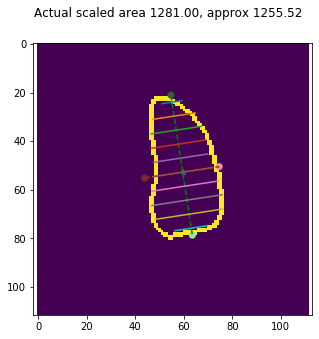

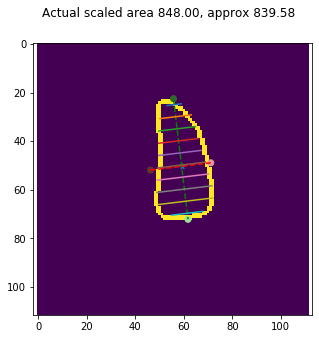

In [10]:
patient_filename = []

EF_list = []
true_EF_list = []
mean_EF_list = []

lv_ed_dice = []
lv_es_dice = []

num_clips = 5
step = 1
interpolate_last = True
fuse_method = "simple"
class_list = [0, 1]
# class_list = None

start = time.time()

#for i in range(len(test_dataset)):
for i in range(1):
    test_pat_index = i
    try:
        video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]
    except:
        print("Get exception when trying to read the video from patient:{:04d}".format(i))
        continue

    if test_pat_index == 1053:
        video = video[:, :80]
    
    segmentations = segment_a_video_with_fusion(video, interpolate_last=interpolate_last, 
                                                step=step, num_clips=num_clips,
                                                fuse_method=fuse_method, class_list=class_list)

    predicted_efs = compute_ef_using_putative_clips(segmentations, test_pat_index=test_pat_index)
    
    _, ed_dice, es_dice = compute_ef_using_reported_clip(segmentations, ed_index, es_index)

    lv_ed_dice.append(ed_dice)
    lv_es_dice.append(es_dice)
    
    if len(predicted_efs) == 0:
        print("Cannot identify clips at patient:{:04d}".format(test_pat_index))
        continue
    
    if np.isnan(np.nanmean(predicted_efs)):
        print("Cannot identify clips at patient:{:04d}".format(test_pat_index))
        continue
               
    EF_list.append(predicted_efs)
    true_EF_list.append(EF)
    mean_EF_list.append(np.nanmean(predicted_efs))
    patient_filename.append(filename[:-4])
    
end = time.time()

print("Used time = {:.0f} mins {:.0f} secs".format((end - start) // 60, (end - start) % 60))

### Label fusion of 5 clips with step 1 using full video segmentation

In [11]:
errors = np.array(np.array(true_EF_list) - np.array(mean_EF_list))
abs_errors = abs(errors)

print("Mean absolute error (standard deviation):  {:.4f} ({:.4f}) %".format(np.mean(abs_errors), np.std(abs_errors)))
print("Median absolute error:  {:.4f} %".format(np.median(abs_errors)))
print("Bias +- 1.96 x std:  {:.4f} +- {:.4f}".format(np.mean(errors), 1.96 * np.std(errors)))
print("Percentile of mae 50%: {:6.4f}  75%: {:6.4f}  95%: {:6.4f}".format(np.percentile(abs_errors, 50), np.percentile(abs_errors, 75),
                                                                    np.percentile(abs_errors, 95)))

Mean absolute error (standard deviation):  0.3964 (0.0000) %
Median absolute error:  0.3964 %
Bias +- 1.96 x std:  0.3964 +- 0.0000
Percentile of mae 50%: 0.3964  75%: 0.3964  95%: 0.3964


In [12]:
print("Average ED {:.4f} ({:.4f})".format(np.mean(lv_ed_dice), np.std(lv_ed_dice)))
print("Median ED {:.4f}".format(np.median(lv_ed_dice)))
print("Average ES {:.4f} ({:.4f})".format(np.mean(lv_es_dice), np.std(lv_es_dice)))
print("Median ES {:.4f}".format(np.median(lv_es_dice)))

Average ED 0.9655 (0.0000)
Median ED 0.9655
Average ES 0.9272 (0.0000)
Median ES 0.9272


In [13]:
pucks_ed

[58.391077983939056,
 array([ 4.22087379,  8.81451694, 10.33703132, 11.24984396, 11.17020085,
        12.46742182, 13.72290996, 14.68909441, 14.04812698,  6.78921575])]

In [14]:
pucks_es

[50.08473921945582,
 array([ 2.92807128,  6.50549207,  7.62568876,  8.24189318,  8.78180122,
         9.96154274, 10.60408082, 11.39197612, 11.32255724,  6.45282475])]